# What would it look like to sample from a conditional multivariate gaussian? 

In [1]:
%pylab inline
import numpy as np
from numpy.random import normal, multivariate_normal
import seaborn as sns; sns.set(style="whitegrid")
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Magic code from [gongyiliao's blog post with python code for the conditional multivariate normal distribution](https://gongyiliao.wordpress.com/2010/01/01/python-code-for-conditional-multivariate-normal-distribution/):

In [2]:
from scipy import *
from scipy.linalg import *
from numpy.random import *
from scipy.stats.distributions import *

def qCondMVnor(P, rsNormVec, cpar, meanVec, covMatx):
    x2 = delete(rsNormVec, cpar)
    mu2 = delete(meanVec, cpar)
    mu1 = meanVec[cpar]
    cov22 = delete(delete(covMatx, s_[cpar], axis=0), s_[cpar], axis=1)
    cov12 = delete(covMatx[1,:], cpar, axis=1)
    cov21 = delete(covMatx[:,1], cpar, axis=0)
    sd = float(sqrt(covMatx[cpar, cpar] - cov12*inv(cov22)*cov21))
    mean = float(mu1 + cov12*inv(cov22)*(matrix(x2 - mu2).reshape(2,1)))
    return norm.ppf(P, loc=mean, scale=sd)

## Taking it apart

In [3]:
delete?

```
Return a new array with sub-arrays along an axis deleted. For a one
dimensional array, this returns those entries not returned by
`arr[obj]`.

Examples
--------
>>> arr = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
>>> arr
array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])
>>> np.delete(arr, 1, 0)
array([[ 1,  2,  3,  4],
       [ 9, 10, 11, 12]])
```

In [4]:
norm.ppf?

```
Signature: norm.ppf(q, *args, **kwds)
Docstring:
Percent point function (inverse of `cdf`) at q of the given RV.

Parameters
----------
q : array_like
    lower tail probability
arg1, arg2, arg3,... : array_like
    The shape parameter(s) for the distribution (see docstring of the
    instance object for more information)
loc : array_like, optional
    location parameter (default=0)
scale : array_like, optional
    scale parameter (default=1)

Returns
-------
x : array_like
    quantile corresponding to the lower tail probability q.
File:      ~/Desktop/KVH/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method
```

In [5]:
s_?

(see https://docs.scipy.org/doc/numpy/reference/generated/numpy.s_.html)

```
Type:        IndexExpression
String form: <numpy.lib.index_tricks.IndexExpression object at 0x1121a5208>
File:        ~/Documents/proteomics/venv/lib/python3.6/site-packages/numpy/lib/index_tricks.py
Docstring:  
A nicer way to build up index tuples for arrays.
```

## Assuming the code follows the [wikipedia article](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions) pretty closely, I can change the code to...

In [6]:
from scipy import *
from scipy.linalg import *
from numpy.random import *
from scipy.stats.distributions import *

def qConditionalMultivariateNormal(rsNormVec, cpar, meanVec, covMatx):
    # Comments are hypotheses as to what things represent.
    # `rsNormVec` is ???
    # `cpar` is "conditional part" or the indices into the meanVec and covMatrix which we condition upon
    # `meanVec` is the means of the distribution
    # `covMatrix` is the covariance matrix of the distribution
    
    x2 = delete(rsNormVec, cpar)
    # x2 is the rsNormVec without the conditional part. What is rsNormVec? What is x?

    mu2 = delete(meanVec, cpar)
    # mu2 is the means without the conditional part. mu2 is the actual variable means.
    
    mu1 = meanVec[cpar]
    # mu1 is the complement of mu2, the conditional means
    
    cov22 = delete(delete(covMatx, s_[cpar], axis=0), s_[cpar], axis=1)
    # cov22 is the conditional part x conditional part covariances
    
    cov12 = delete(covMatx, cpar, axis=1)
    # cov12 is the conditional part x variable covariances
    
    cov21 = delete(covMatx, cpar, axis=0)
    # cov21 is the variable x conditional part covariances
    
    # Now, according to the wikipedia page: (x1 | x2 = a) ~ N(μ, Σ) where
    # μ = m1 + cov12 * inv(cov22) * (a - mu2)
    # Σ = cov11 - cov12 * inv(cov22) * cov21
    # and that's roughly what we see below: 
    
    mean = float(mu1 + cov12*inv(cov22)*(matrix(x2 - mu2).reshape(2,1)))
    sd = float(sqrt(covMatx[cpar, cpar] - cov12*inv(cov22)*cov21))
    
    # somehow, (matrix(x2 - mu2).reshape(2,1)) is (a - mu2)
    
    # now, with `mean` and `sd`, we should be able to sample (x1 | x2 = a) ~ N(μ, Σ)
    # return normal(mean, sd)
    return multivariate_normal(mean, sd)  # which one of the above is right? 

## Let's try plotting distributions in 2D -- we'll need this for debugging anyhow 

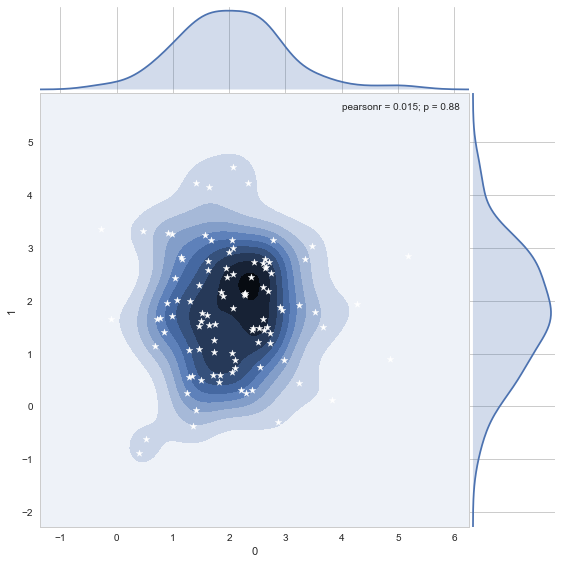

In [7]:
samples = pd.DataFrame([multivariate_normal(np.array([2, 2]), np.array([[1, 0], [0, 1]])) for x in range(100)])
p = sns.jointplot(samples[0], samples[1], size=8, space=0, kind='kde').plot_joint(plt.scatter, color='white', marker="*")

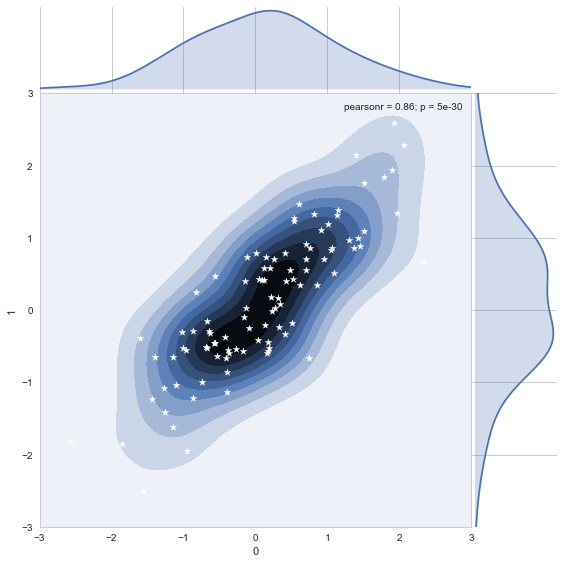

In [8]:
samples = pd.DataFrame([multivariate_normal(np.array([0, 0]), np.array([[1, 0.8], [0.8, 1]])) for x in range(100)])
p = sns.jointplot(samples[0], samples[1], size=8, space=0, kind='kde', xlim=(-3, 3), ylim=(-3, 3)).plot_joint(plt.scatter, color='white', marker="*")

## Let's try sampling...

In [9]:
rsNormVec = np.array([1])
cpar = 0
meanVec = np.array([0, 0])
covMatx = np.array([[0.9, 0.5], 
                    [0.5, 0.3]])

qConditionalMultivariateNormal(rsNormVec, cpar, meanVec, covMatx)

[]
[0]


ValueError: cannot reshape array of size 0 into shape (2,1)

In [11]:
x2 = delete(rsNormVec, cpar)
# x2 is the rsNormVec without the conditional part. What is rsNormVec? What is x?
x2

array([], dtype=int64)

In [13]:
mu2 = delete(meanVec, cpar)
# mu2 is the means without the conditional part. mu2 is the actual variable means.

mu1 = meanVec[cpar]
# mu1 is the complement of mu2, the conditional means

cov22 = delete(delete(covMatx, s_[cpar], axis=0), s_[cpar], axis=1)
# cov22 is the conditional part x conditional part covariances

cov12 = delete(covMatx, cpar, axis=1)
# cov12 is the conditional part x variable covariances

cov21 = delete(covMatx, cpar, axis=0)
# cov21 is the variable x conditional part covariances

# Now, according to the wikipedia page: (x1 | x2 = a) ~ N(μ, Σ) where
# μ = m1 + cov12 * inv(cov22) * (a - mu2)
# Σ = cov11 - cov12 * inv(cov22) * cov21
# and that's roughly what we see below: 

mean = float(mu1 + cov12*inv(cov22)*(matrix(x2 - mu2).reshape(2,1)))
sd = float(sqrt(covMatx[cpar, cpar] - cov12*inv(cov22)*cov21))

ValueError: cannot reshape array of size 0 into shape (2,1)